# <center> Vehicle detection in dashcam videos </center>

## <center> Antoine Dargier </center>

### <center> March 15, 2023 </center>

## 1. Import packages and librairies


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Preprocessing

In [3]:
def data_look(car_list, notcar_list):
    """
    input : car_list, notcar_list : 2 lists of pictures
    output : a dictionnary with number of cars and non cars pictures, image shape and data type
    """
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    car_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_img.dtype
    # Return data_dict
    return data_dict

In [4]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    """
    Shows input images by stacking them in num_cols columns
    """
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

### 2.1 Load data

In [5]:
import glob

#Read cars and not-cars images

#Data folders
vehicles_dir =     './data3/vehicles/'
non_vehicles_dir = './data3/non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        cars.append(image)
        
# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        notcars.append(image)
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


### 2.2 Visualize sample images for car and not car types

Example Car images


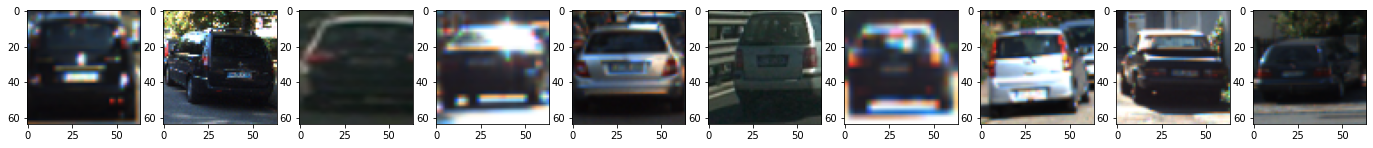

Example not-car images


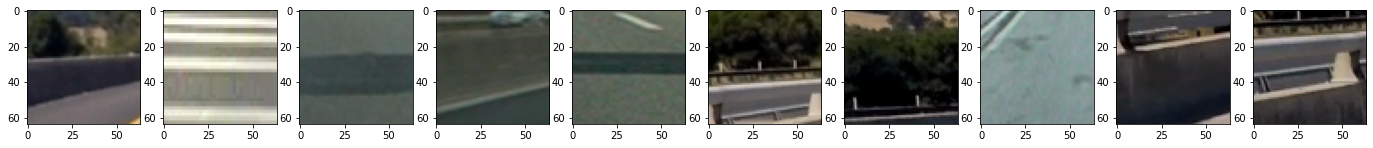

In [6]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random car / not-car indices and plot example images   
cars_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)
    
# Read in car / not-car images
car_images = []
notcar_images = []
for sample in cars_samples:
    car_images.append(mpimg.imread(sample))
    
for sample in notcar_samples:
    notcar_images.append(mpimg.imread(sample))

visualize_images(car_images, num_images, "Example Car images")
visualize_images(notcar_images, num_images, "Example not-car images")

### 2.3 Print example of YUV channel, which seems to be the most differentiable

Text(0.5, 1.0, 'YUV')

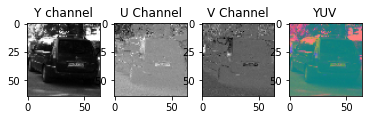

In [7]:
# # Plot the examples
fig = plt.figure()
plt.subplot(141)
yuv_image = cv2.cvtColor(car_images[1], cv2.COLOR_RGB2YUV)
plt.imshow(yuv_image[:,:,0], cmap ="gray")
plt.title('Y channel')
plt.subplot(142)
plt.imshow(yuv_image[:,:,1], cmap ="gray")
plt.title('U Channel')
plt.subplot(143)
plt.imshow(yuv_image[:,:,2], cmap ="gray")
plt.title('V Channel')
plt.subplot(144)
plt.imshow(yuv_image)
plt.title('YUV')

### 2.4 Create Hog features extraction features

In [8]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

### 2.5 Print examples of Hog features on cars and not cars

Text(0.5, 1.0, 'not car HOG Visualization')

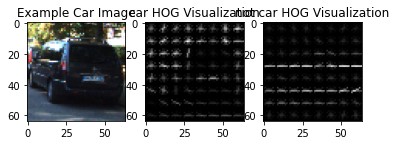

In [9]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features, hog_image = get_hog_features(cv2.cvtColor(car_images[1], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notcar_features, notcar_hog_image = get_hog_features(cv2.cvtColor(notcar_images[2], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(car_images[1])
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('car HOG Visualization')
plt.subplot(133)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('not car HOG Visualization')

### 2.6 Define the function to extract all features needed

In [10]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [11]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)   

            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 3. Train the SVM classifier on the features

In [13]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32

t=time.time()

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

869.75 Seconds to extract HOG features...
(17760, 5292)
17760
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
44.44 Seconds to train SVC...


In [14]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9831
My SVC predicts:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
0.0282 Seconds to predict 10 labels with SVC


## 4. Detect vehicles on the test images

### 4.1 Load the test images

In [15]:
#Read cars and not-cars images

#Data folders
test_images_dir = './test/'

# images are divided up into vehicles and non-vehicles
test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
        test_images.append(mpimg.imread(image))

### 4.2 Find cars

In [16]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = False):
    """
    function that extract features on pictures and make prediction
    """
    draw_img = np.copy(img)
    xstart = 0
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    rectangles = []

    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = X_scaler.transform(hog_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or vis_bboxes == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                              
    return rectangles

### 4.3 Draw bounding boxes

In [17]:
#parameters to play with to adjust the bounding boxes
scales_list = [1, 2, 3.2]
ystarts_list = [165, 190, 190]
ystops_list = [350, 470, 450]
threshold_val = 2

In [18]:
def get_rectangles(image, scales = scales_list, ystarts = ystarts_list, ystops = ystops_list):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 
    return out_rectangles

In [19]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [20]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [21]:
def draw_labeled_bboxes(img, labels):
    img_copy = np.copy(img)
    result_rectangles = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            result_rectangles.append(bbox)
            cv2.rectangle(img_copy, bbox[0], bbox[1], (0,255,0), 6)
    return result_rectangles, img_copy

In [22]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    sizes = []
    for bbox in bboxes:
        size = bbox[1][0]-bbox[0][0]
        if size not in sizes:
            sizes.append(size)
    for bbox in bboxes:
        if bbox[1][0]-bbox[0][0]==sizes[0]:
            color = (0,0,255)
        elif bbox[1][0]-bbox[0][0]==sizes[1]:
            color = (0,255,0)
        else :
            color = (255,0,0)
            

        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [23]:
def visualize_bboxes(image, scales = scales_list, 
                   ystarts = ystarts_list, 
                   ystops = ystops_list):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = True)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

    plt.figure(figsize=(20,10))
    plt.imshow(draw_boxes(image, out_rectangles, color='random', thick=3))

#### Visualize the sliding windows

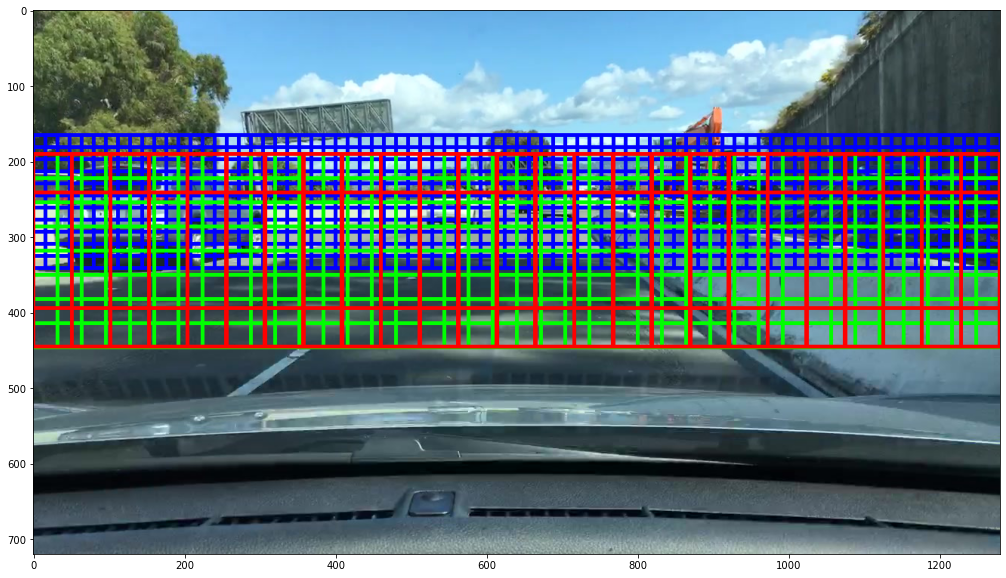

In [24]:
visualize_bboxes(test_images[7])

### 4.4 Pipeline and results

In [25]:
from scipy.ndimage.measurements import label

result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
for test_image in test_images[100:110]:
    rectangles = get_rectangles(test_image)
    result_img_all_boxes.append(draw_boxes(test_image, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(test_image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, threshold_val)
    labels = label(heatmap_image)
    rectangles, result_image = draw_labeled_bboxes(test_image, labels)
    result_boxes.append(rectangles)
    result_images.append(result_image)

#### 4.4.1 Show all windows with cars

test


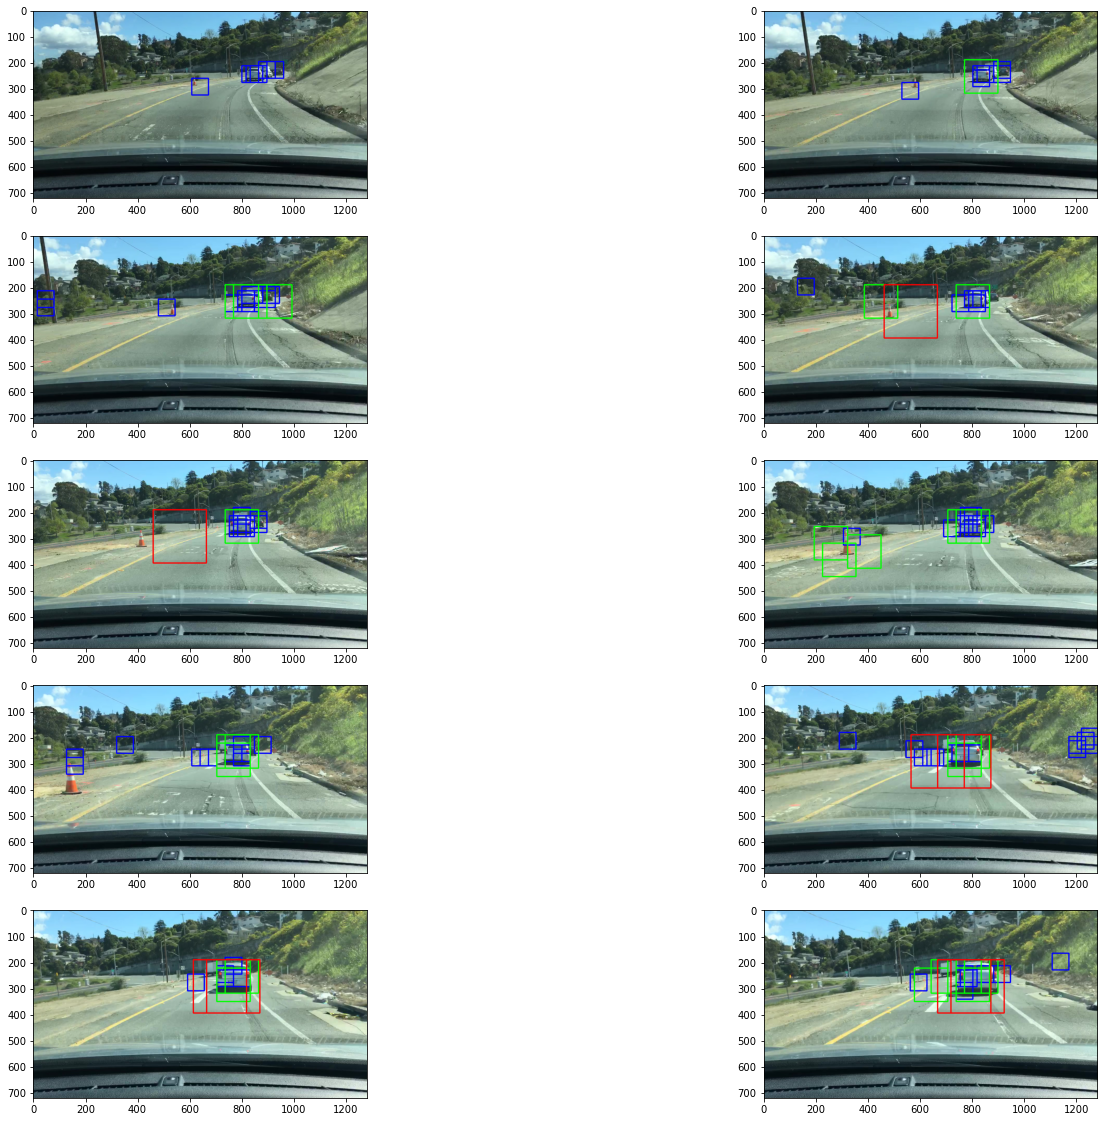

In [26]:
visualize_images(result_img_all_boxes, 2, "test")

#### 4.4.2 Show bounding boxes retained

test


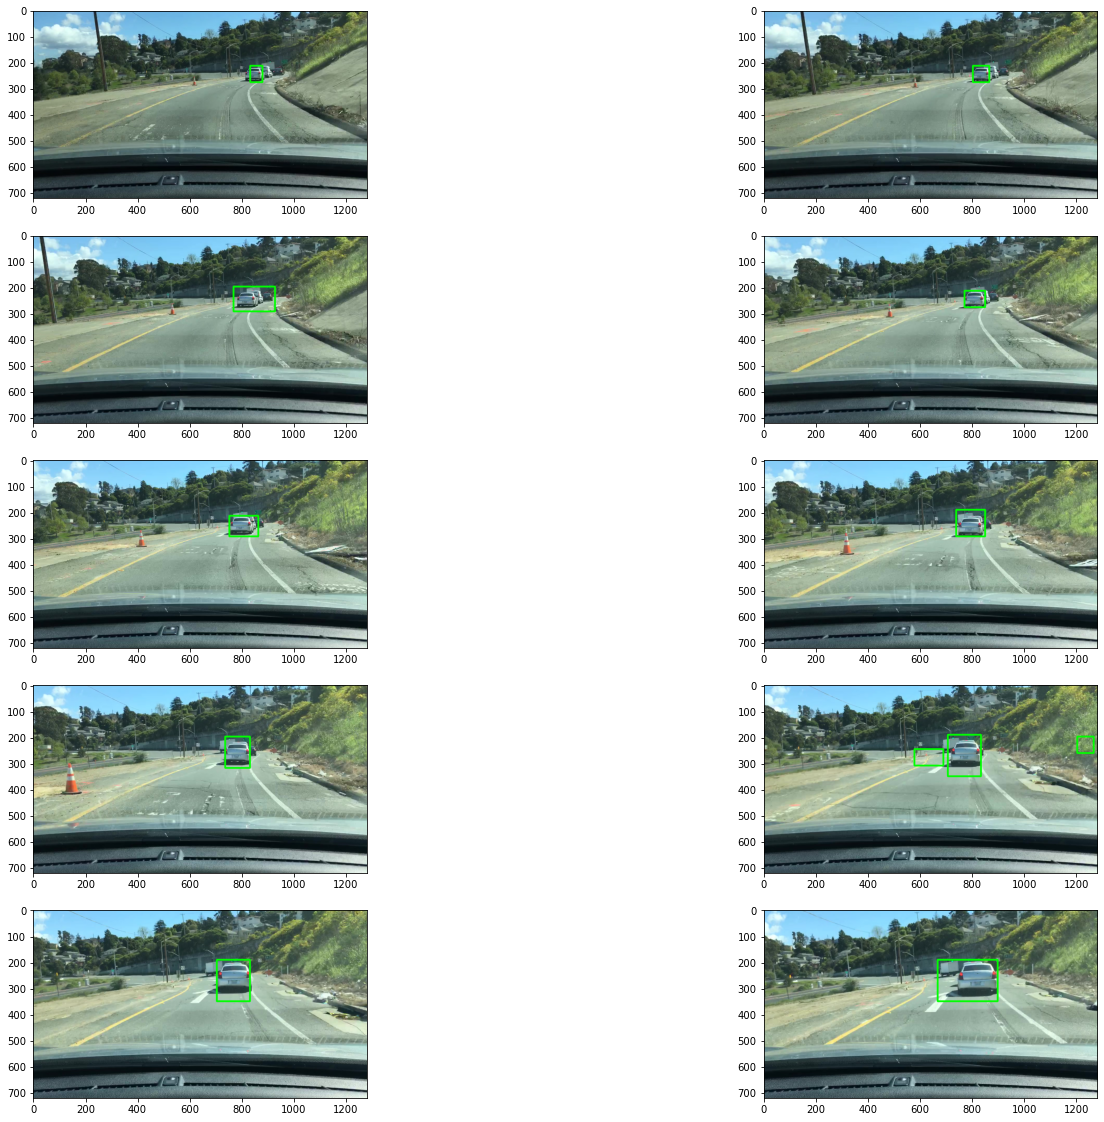

In [27]:
visualize_images(result_images, 2, "test")

#### 4.4.3 Show heatmaps

Heatmap


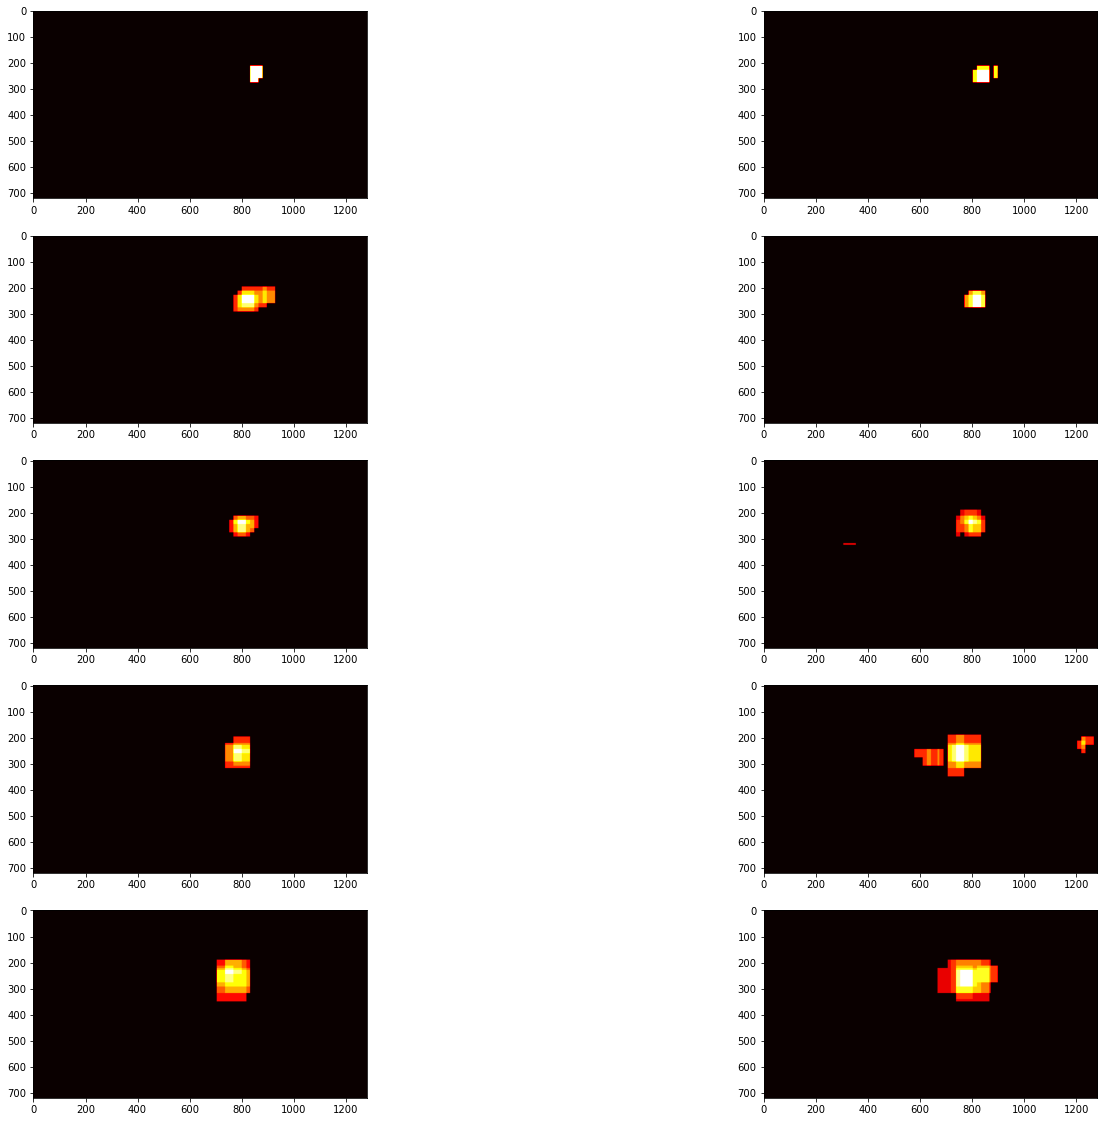

In [28]:
visualize_images(heatmap_images, 2, "Heatmap", cmap="hot")

## 5. Predictions

In [29]:
H, W = 720, 1280

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    if bounding_boxes != []:
        for x, y, dx, dy in bounding_boxes:
            mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """

    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]

    if len(non_zeros) == 0:
        return ''
    
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [313]:
result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
rows = []
test_names = os.listdir("./test")
N = len(test_images)
for i, test_image in enumerate(test_images):    
    file_name = test_names[i]
    rectangles = get_rectangles(test_image)
    result_img_all_boxes.append(draw_boxes(test_image, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(test_image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, threshold_val)
    labels = label(heatmap_image)
    rectangles, result_image = draw_labeled_bboxes(test_image, labels)
    bounding_boxes = []
    for rectangle in rectangles:
        x, y, dx, dy = rectangle[0][0], rectangle[0][1], rectangle[1][0]-rectangle[0][0], rectangle[1][1]-rectangle[0][1]
        bounding_boxes.append([x, y, dx, dy])
    
    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes, H, W))
    rows.append(['test/' + file_name, rle])
    
    if i%10==0:
        print(f'{100*i/N}% done')
        
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('sample_submission_2.csv')

0.0% done
4.9504950495049505% done
9.900990099009901% done
14.851485148514852% done
19.801980198019802% done
24.752475247524753% done
29.702970297029704% done
34.65346534653465% done
39.603960396039604% done
44.554455445544555% done
49.504950495049506% done
54.45544554455446% done
59.40594059405941% done
64.35643564356435% done
69.3069306930693% done
74.25742574257426% done
79.20792079207921% done
84.15841584158416% done
89.10891089108911% done
94.05940594059406% done
99.00990099009901% done
